# AE-LEGO Experiments setup
This notebook defines exploration utilities.

* [Dataset](#data)
* [Loss exploration setup](#loss)
* [Experiment setup](#exp)
* [Test run](#test):
    * [VAE](#vae): [reconstruction only; low weight](#vae)
    * [VAE](#vae): [reconstruction only; with different weight](#vae1)
    * [DVAE](#dvae): [reconstruction only; low weight](#dvae)
    * [DVAE](#dvae): [reconstruction only; with different weight](#dvae1)
    * [Twin-VAE](#twin): [reconstruction only; low weight](#twin)
    * [Hydra-VAE](#hvae): [reconstruction only; low weight](#hvae)
    * [Hydra-DVAE](#hdvae): [reconstruction only; low weight](#hdvae)
    


In [1]:
import torch
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import colormaps, ticker
from IPython.display import SVG

from torch import nn
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torch.optim import SGD, AdamW
from torchsummary import summary

from torchvision.datasets import MNIST

In [2]:
from scripts.backbone import *
from scripts.aelego import *
from scripts.experiment import *
from scripts.utils import *

In [3]:
torch.cuda.empty_cache()
print('GPU' if DEVICE == 'cuda' else 'no GPU')

GPU


<a name="data"></a>

## Dataset
MINST is a good fit for this simple experiment: it is categorical but also continuous.

In [4]:
trainset = MNIST(root='./data', train=True, download=True)
testset  = MNIST(root='./data', train=False, download=True)

Semantic channel can be defined by some set of labels: it could be labels from the data, or something else entirely.

    # use data labels
    SEMANTIC_DIM = 10
    SEMANTIC_LABELS = list(range(10))
    dataset = AEDataset

    # make up some labels
    class ContextDataset(AEDataset):
        def __getitem__(self, idx):
            X, Y, C = super().__getitem__(idx)
            labels = {1:0, 4:0, 7:0, 0:1, 8:1, 2:2, 3:2, 5:2, 6:3, 9:3}
            return X, Y, labels[C]

    SEMANTIC_DIM = 4
    SEMANTIC_LABELS = ['1,4,7','0,8','2,3,5','6,9']
    dataset = ContextDataset

In [5]:
    SEMANTIC_DIM = 0
    SEMANTIC_LABELS = []
    dataset = AEDataset

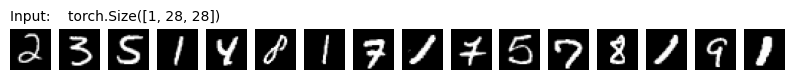

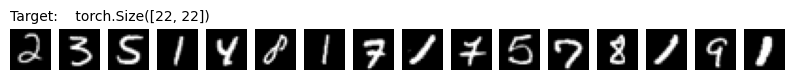

(torch.Size([16, 1, 28, 28]),
 torch.Size([16, 22, 22]),
 tensor([2, 3, 5, 1, 4, 8, 1, 7, 1, 7, 5, 7, 8, 1, 9, 1]))

In [6]:
# make demo-batch
for demo_batch in DataLoader(dataset(testset), batch_size=16, shuffle=True):
    X, Y, C = demo_batch
    break
show_inputs(demo_batch)
show_targets(demo_batch)
X.shape, Y.shape, C

<a name="loss"></a>

## Loss exploration setup
Let's construct our loss function. The utility below takes configuration with fixed parameters for our main objective (reconstruction) and initializes trainable parameters for other [losses introduced in the lego-blocks notebook](VAE-LEGO.ipynb#loss). A trainable parameter `tau` controls the level of the noise in the system.
We calculate and track all the losses we defined including those not being used for training -- this will allow us to have a bigger picture of and get some intuition.

In [7]:
class LossExplorer(nn.Module):
    """
    Trainable mixer with opinionated init and visual evaluation utilities
    """
    # reconstruction keys (static value; required)
    REC = ['rec-AE', 'rec-VAE', 'rec-DVAE']
    # regularizer keys (could be trainable; optional)
    KEYS = REC + ['KLD-Gauss', 'KLD-Gumbel',
                  'Contrast-Gauss', 'Contrast-Gumbel',
                  'Align-Gauss', 'Align-Gumbel',
                  'Temperature']
    
    def __init__(self, keys: list, conf: dict, categorical_dim: int = None, trainable: bool = False):
        super().__init__()
        # outputs ids
        self.keys = keys
        
        # initialize losses all on their "native" scale of magnitude as static
        self.loss = {
            'Reconstruction':  ReconstructionLoss(nn.MSELoss(reduction='mean')),
            'KLD-Gauss':       KLDGaussianLoss(reduction='mean'),
            'KLD-Gumbel':      KLDGumbelLoss(categorical_dim, reduction='mean'),
            'Contrast-Gauss':  ContrastLoss(),
            'Contrast-Gumbel': ContrastLoss(),
            'Align-Gauss':     AlignLoss(),
            'Align-Gumbel':    AlignLoss(),
            # model "termometer": controls level of noise
            'Temperature':     TauLoss(),
        }
        # build configuration
        init, order, weight = [],[],{}
        for key in config:
            if not key in self.KEYS:
                raise Exception(f'Unknown key: {key}')
            if key in self.REC: # first priority non-trainable static weight
                weight[key] = conf[key]
            else: # regularizers with trainable if configured weights
                init.append(conf[key])
                order.append(key)
        self.mixer = torch.Tensor(init)
        if trainable:
            self.mixer = nn.Parameter(self.mixer)
        self.order = order
        self.weight = weight
        self.trainable = trainable
        print(f'Mixer: {self.order} {self.mixer}')        
        # track all components separately
        self.window, self.track = 20, []
        self.history, self.buffer = {'train':[],'test':[]}, {'train':[],'test':[]}
        
    def log(self, *args, finish=False):
        """
        R&D only: windowed training and validation history for each key component
        """
        key = 'train' if self.training else 'test'
        if not finish:
            self.buffer[key].append(tuple(args))
        if len(self.buffer[key]) >= (1 if finish else self.window):
            n = len(self.buffer[key])
            self.history[key].append([sum([x[i] for x in self.buffer[key]])/n for i in range(len(args))])
            self.buffer[key] = []
                
    def forward(self, outputs, targets):
        loss = {}
        # unpack inputs and calculate all losses (even those not in config)
        for i, (k, v) in enumerate(zip(self.keys, outputs)):
            if k in self.REC:
                loss[k] = self.loss['Reconstruction'](v, targets)
            elif k == 'mean':
                loss['KLD-Gauss'] = self.loss['KLD-Gauss'](v, outputs[i + 1])
                loss['Contrast-Gauss'] = self.loss['Contrast-Gauss'](v)
            elif k == 'z': ### do mean instead of z for more stable training
                z = v
            elif k == 'log-variance':
                assert 'KLD-Gauss' in loss
            elif k == 'q':
                loss['KLD-Gumbel'] = self.loss['KLD-Gumbel'](v)
                loss['Contrast-Gumbel'] = self.loss['Contrast-Gumbel'](v)
            elif k == 'p': ### do q instead of p for more stable training
                p = v
            elif k == 'z-context':
                loss['Align-Gauss'] = self.loss['Align-Gauss'](z, v)
            elif k == 'p-context':
                loss['Align-Gumbel'] = self.loss['Align-Gumbel'](p, v)
            elif k == 'tau':
                tau = v.squeeze()
                loss['Temperature'] = self.loss['Temperature'](tau)
                
        # track all variables in their original scale for visual evaluation
        vals = [loss[x].item() for x in self.KEYS if x in loss]
        keys = [k for k in self.KEYS if k in loss]
        vals += [self.mixer[self.order.index(k)].item() if k in self.order else 0 for i,k in enumerate(keys)]
        self.log(*vals)
        self.track = keys
        
        rec = [loss[k] * np.exp(self.weight[k]) for k in self.REC if k in loss]
        # use only those included in config
        mix = [loss[k] for k in self.order]
        # exp to prevent erasing components with zero factor
        loss = torch.sum(torch.stack(rec + [torch.exp(f) * v for f, v in zip(self.mixer, mix)]))
        # add mixer regularization
        return loss + torch.sum(self.mixer.pow(4))


<a name="exp"></a>

## Experiment setup

In [8]:
def experiment(model: nn.Module,
               tag: str,
               init: dict,
               latent_dim: int,
               categorical_dim: int = None,
               encoder_semantic_dim: int = 0,
               decoder_semantic_dim: int = 0,
               trainable: bool = False,
               tau: float = 0.1,
               dataset: Dataset = AEDataset,
               demo_batch: tuple = None,
               batch_size: int = 16,
               learning_rate: float = 1e-5,
               epochs: int = 3):
    """
    build configuration and run training
    """
    encoder = get_encoder()
    decoder = get_decoder()
    
    context = decoder_semantic_dim > 0 or encoder_semantic_dim > 0
    
    if model == TwinVAE:
        #assert categorical
        model = TwinVAE(encoder, decoder, latent_dim, categorical_dim,
                        encoder_semantic_dim, decoder_semantic_dim, tau).to(DEVICE)
        print('Model: TwinVAE')
    elif model == HydraVAE:
        #dim = CATEGORICAL_DIM if categorical else None
        model = HydraVAE(encoder, decoder, latent_dim, categorical_dim,
                         encoder_semantic_dim, decoder_semantic_dim, tau).to(DEVICE)
        print(f'Model: {"Categorical " if categorical_dim else ""}HydraVAE')
    elif model == DVAE:
        #assert categorical
        model = DVAE(encoder, decoder, latent_dim, categorical_dim,
                     encoder_semantic_dim, decoder_semantic_dim, tau).to(DEVICE)
        print('Model: DVAE')
    else:
        model = VAE(encoder, decoder, latent_dim, 
                    encoder_semantic_dim, decoder_semantic_dim, tau).to(DEVICE)
        print('Model: VAE')

    init['Temperature'] = tau
    criterion = LossExplorer(model.keys, init, categorical_dim, trainable=trainable).to(DEVICE)
    params = [p for p in model.parameters()] + [p for p in criterion.parameters()]
    optimizer = SGD(params, lr=learning_rate, momentum=0.8)

    history, results = [],[]
    for epoch in range(1, epochs + 1):
        
        train_history = train_epoch(model, dataset(trainset), context,
                                    criterion, optimizer, epoch, batch_size=batch_size)
        
        test_history = validate(model, dataset(testset), context,
                                criterion, epoch, batch_size=batch_size)
        
        history.append((np.mean(train_history), np.mean(test_history)))
    criterion.log(None, finish=True)
    k, n = len(criterion.history['test'])//epochs, len(criterion.track)
    for e in range(epochs):
        results.append(np.mean(np.array(criterion.history['test'][k * e:k * (e + 1)])[:,:n], axis=0))
    # show trainig history and return trained model and last test results
    show_progress(model, criterion, history, results, tag, demo_batch)
    return model, {k:v for k,v in zip(criterion.track, results[-1])}
            

In [9]:
LATENT_DIM = 3
CATEGORICAL_DIM = 10

suffix = f'{LATENT_DIM}-{CATEGORICAL_DIM}-0' # for image-save path

kwargs = { # shared arguments
    'encoder_semantic_dim': 0,
    'decoder_semantic_dim': 0,
    'tau': 0.1,
    'dataset': dataset,
    'demo_batch': demo_batch,
    'batch_size': 16,
    'learning_rate': 1e-5,
}

index, results = [],[]

<a name="test"></a>

## Test run
In this test we explore how scale of reconstruction error affects the training.

<a name="vae"></a>

### VAE
This experiment trains VAE optimizing reconstruction only. We intentionally set a low weight for reconstruction error to see what would happen with the other metrics not included in the training in the situation when the gradients for those terms are comparable in magnitude and not restricted.

Model: VAE
Mixer: ['Temperature'] tensor([0.1000])


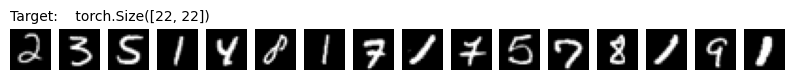

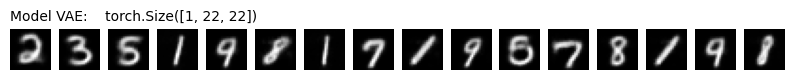

Mixer: tensor([0.1000])


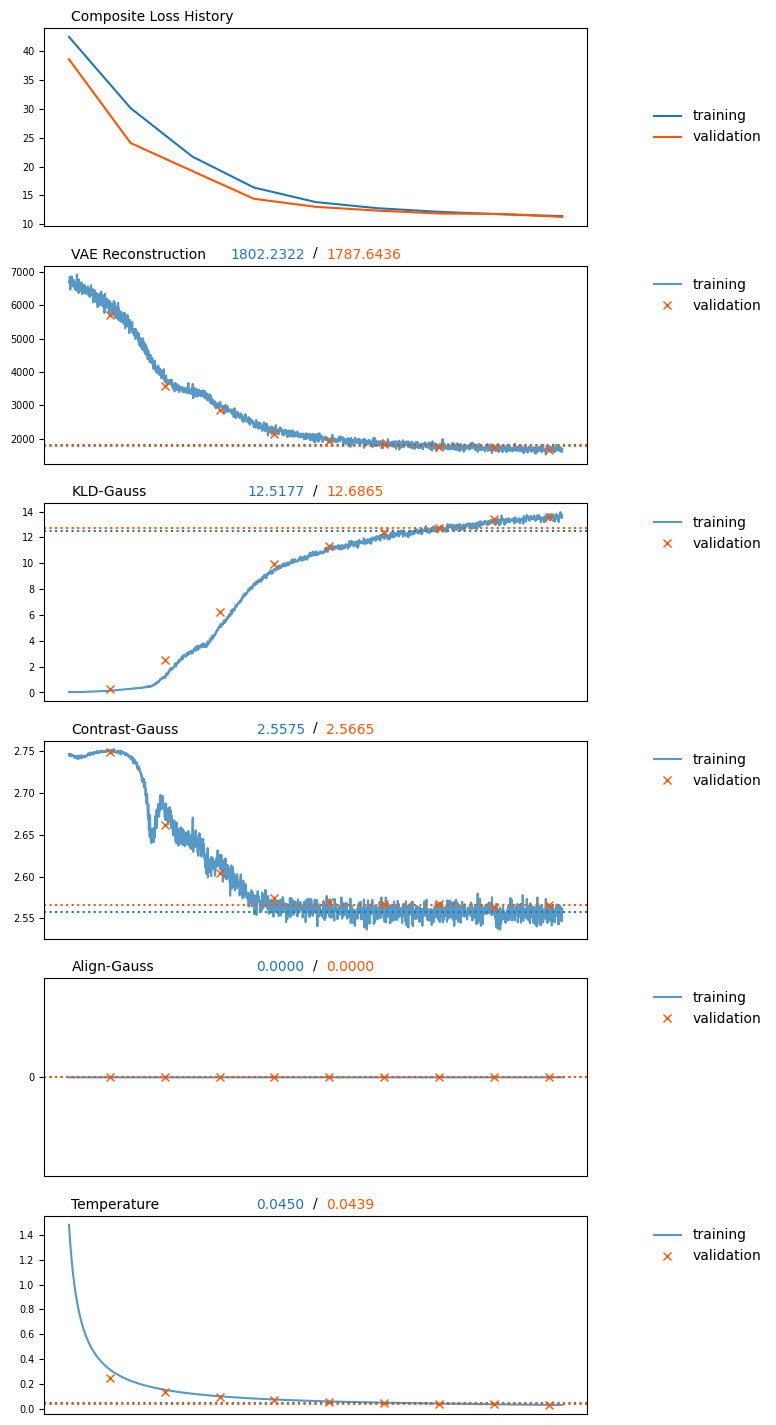

In [10]:
tag = 'vae-test-5'
config = {'rec-VAE': -5.}
model, _ = experiment(VAE, f'{tag}-{suffix}', config, LATENT_DIM, epochs=9, **kwargs)

We can see that MNIST data has an easy sweet spot for Gaussian -- ignore the details and it is always black background with a white blob in the middle. `Contrast` seems to trigger `KLD` eventually move on and up which unlocks further reconstruction error improvement. If we scale up the weight for reconstruction error -- it will push `contrast`, and `KLD` as well.

<a name="vae1"></a>

In [ ]:
for weight in range(-4, 0, 1):
    print(f'\n\n=== Reconstruction loss weight={weight} =========================================\n')
    model, _ = experiment(VAE, f'vae-test{weight}-{suffix}', {'rec-VAE':weight },
                          LATENT_DIM, epochs=3, **kwargs)

<a name="dvae"></a>

### Discrete/Categorical VAE

Model: DVAE
Mixer: ['Temperature'] tensor([0.1000])


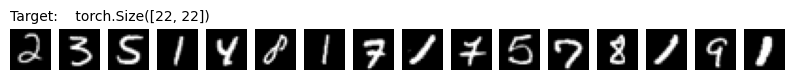

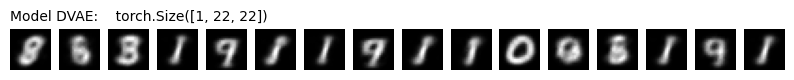

Mixer: tensor([0.1000])


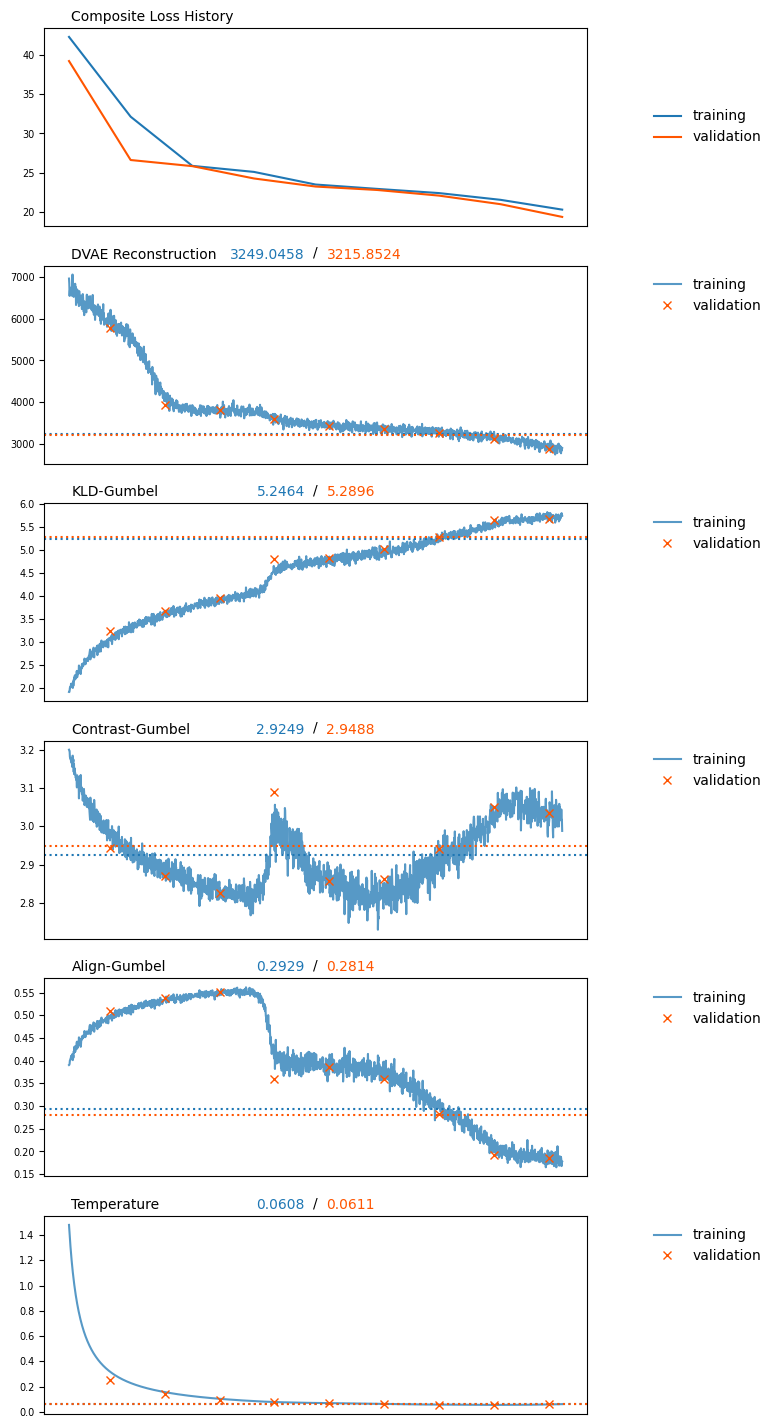

In [12]:
tag = 'dvae-test-5'
config = {'rec-DVAE': -5.}
model = experiment(DVAE, f'{tag}-{suffix}', config, LATENT_DIM, CATEGORICAL_DIM, epochs=9, **kwargs)

<a name="dvae1"></a>

In [ ]:
for weight in range(-4, 0, 1):
    print(f'\n\n=== Reconstruction loss weight={weight} =========================================\n')
    model = experiment(DVAE, f'dvae-test{weight}-{suffix}', {'rec-DVAE':weight },
                       LATENT_DIM, CATEGORICAL_DIM, epochs=3, **kwargs)

<a name="8"></a>

### Twin-VAE

Model: TwinVAE
Mixer: ['Temperature'] tensor([0.1000])


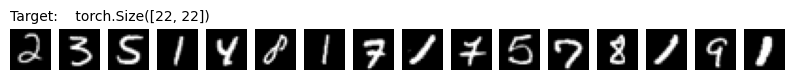

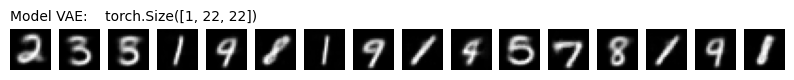

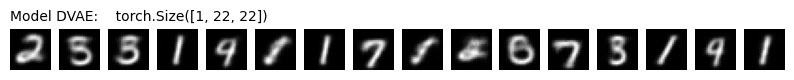

Mixer: tensor([0.1000])


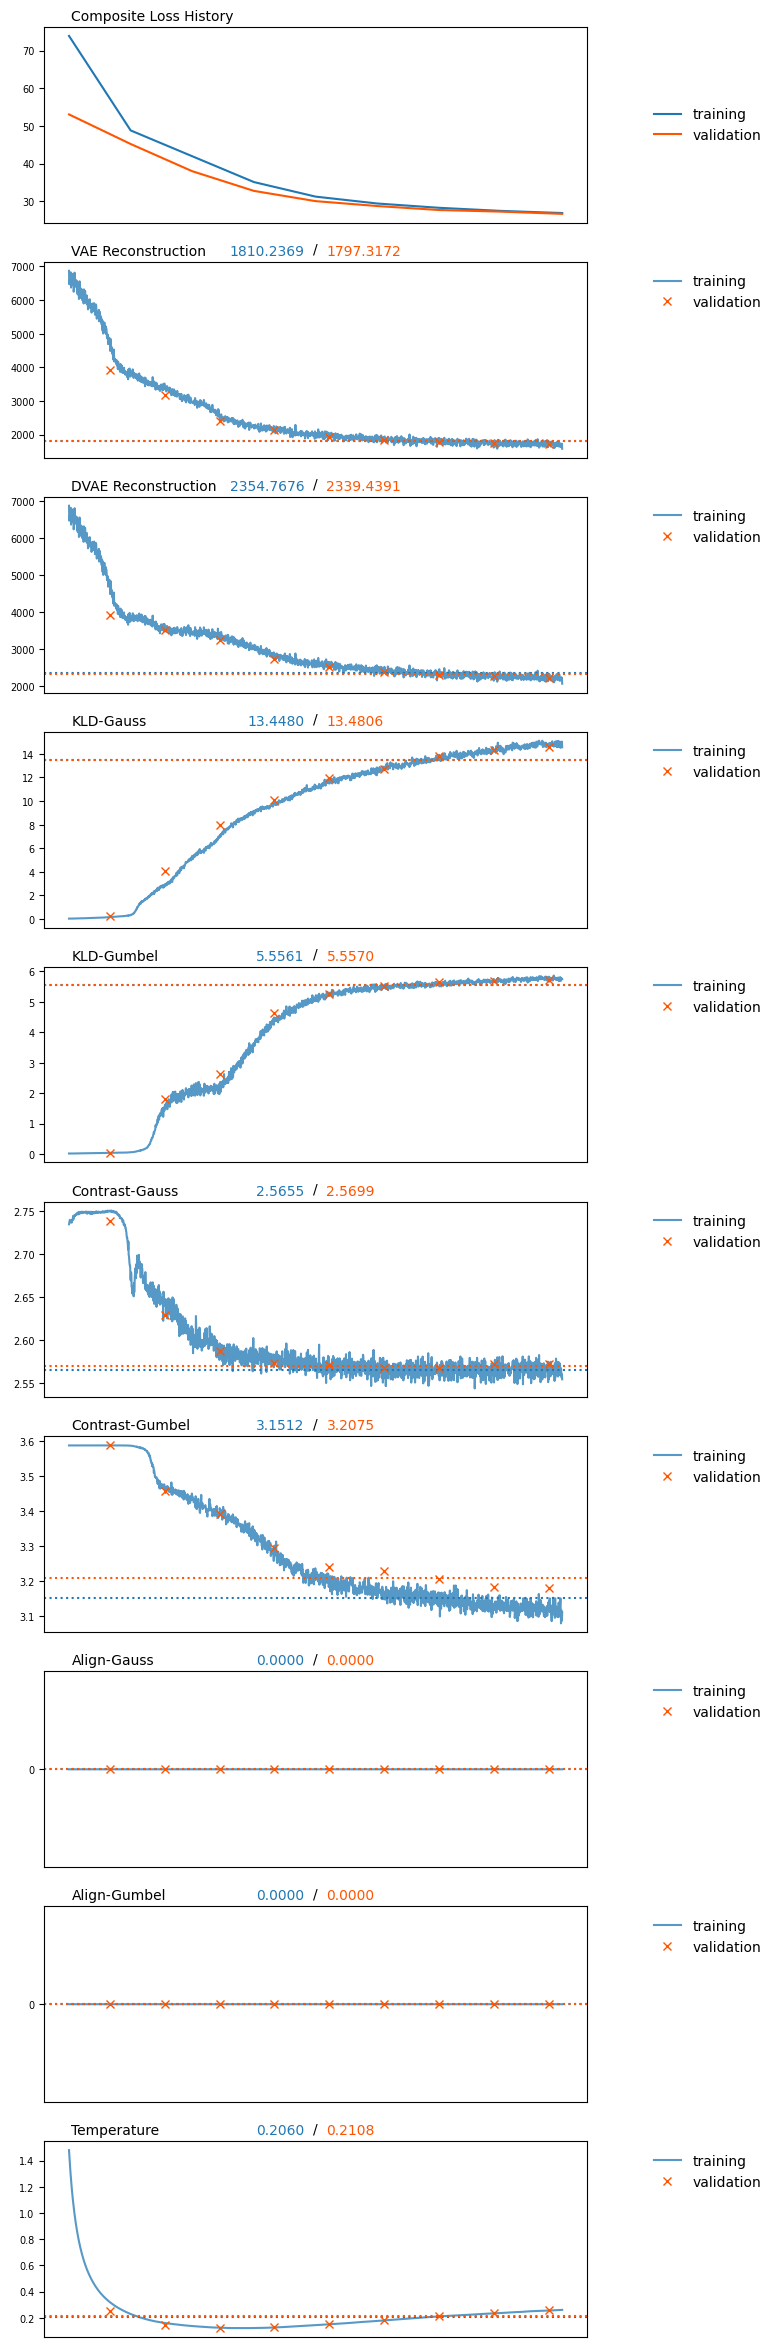

In [14]:
tag = 'twin-test-5'
config = {'rec-VAE': -5., 'rec-DVAE': -5.}
model = experiment(TwinVAE, f'{tag}-{suffix}', config, LATENT_DIM, CATEGORICAL_DIM, epochs=9, **kwargs)

<a name="hvae"></a>

### Hydra-VAE

Model: HydraVAE
Mixer: ['Temperature'] tensor([0.1000])


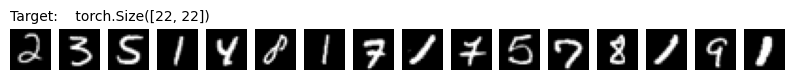

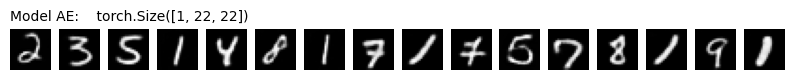

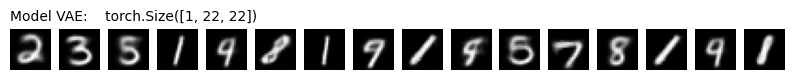

Mixer: tensor([0.1000])


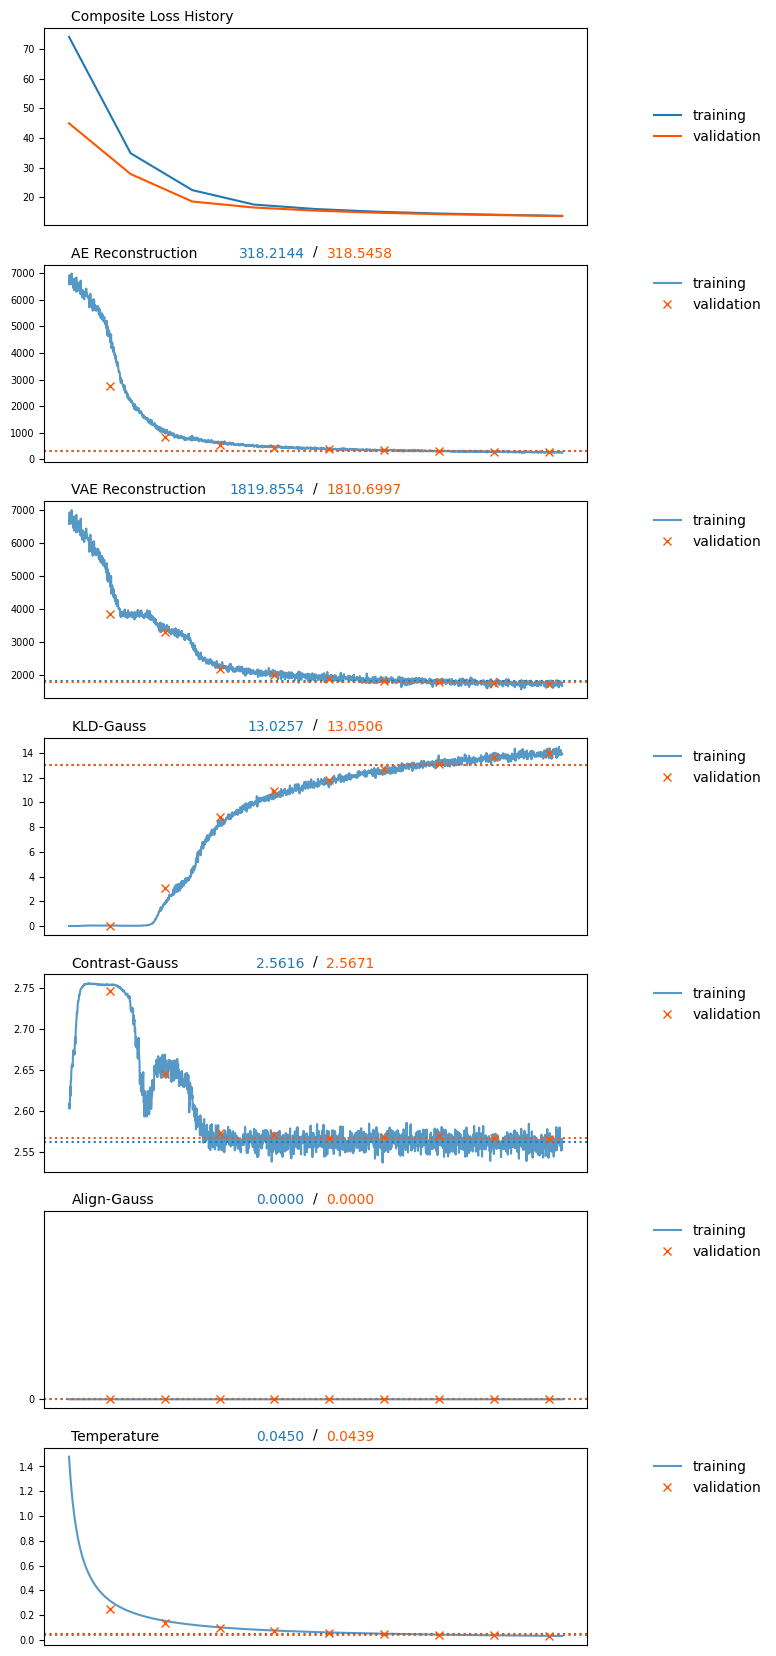

In [15]:
tag = 'hvae-test-5'
config = {'rec-AE': -5., 'rec-VAE': -5.}
model = experiment(HydraVAE, f'{tag}-{suffix}', config, LATENT_DIM, epochs=9, **kwargs)

<a name="hdvae"></a>

### Hydra-DVAE

Model: Categorical HydraVAE
Mixer: ['Temperature'] tensor([0.1000])


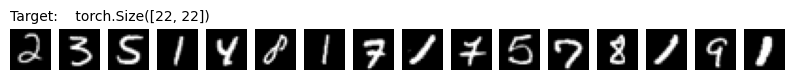

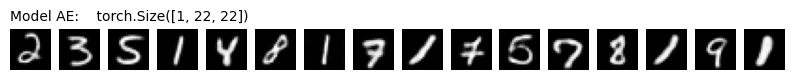

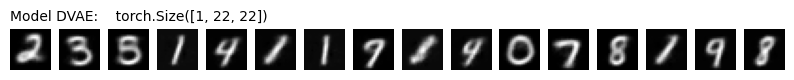

Mixer: tensor([0.1000])


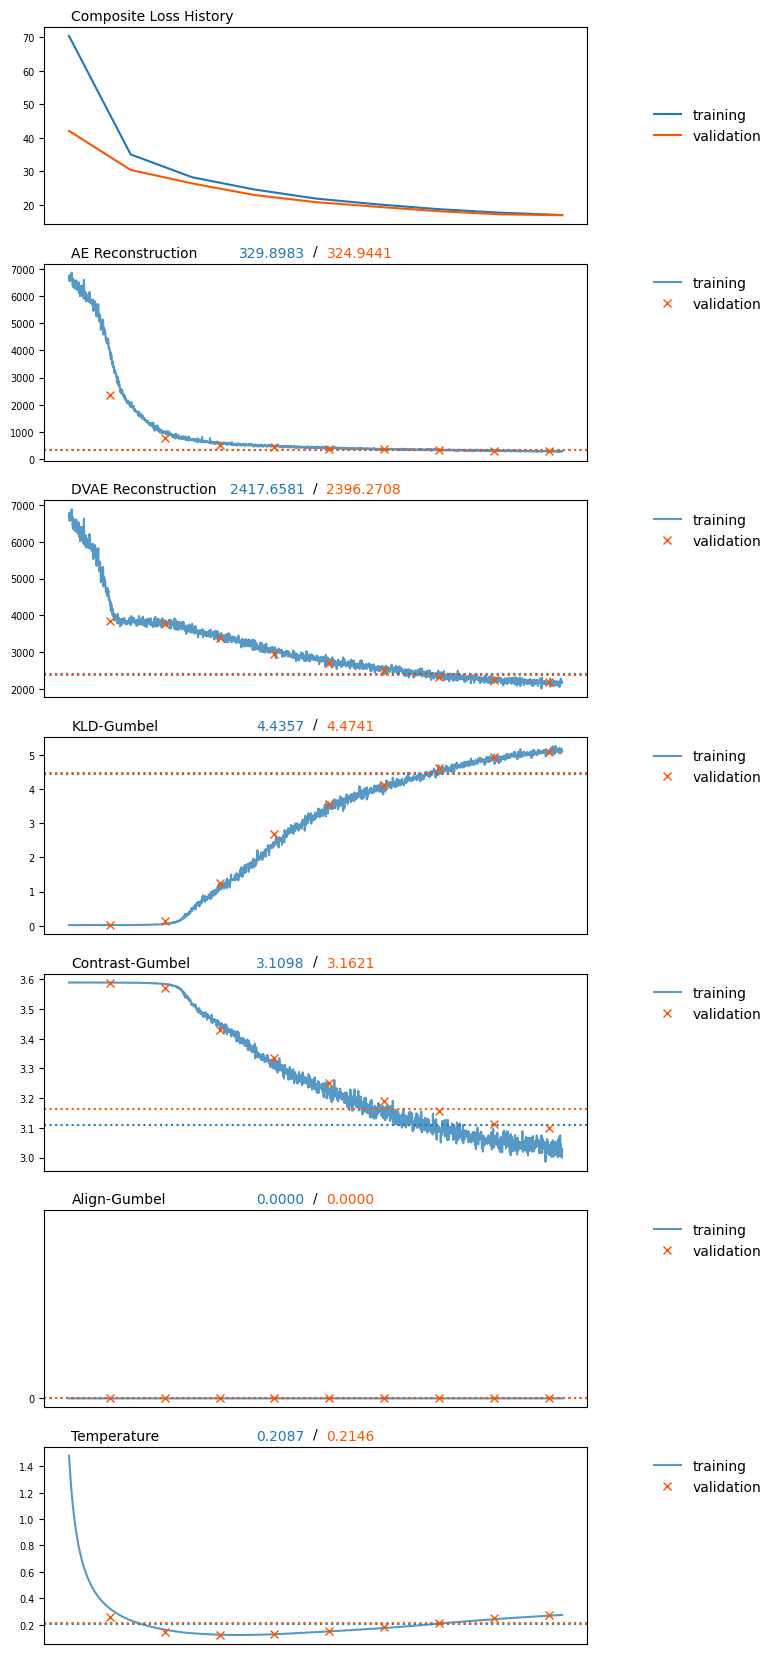

In [16]:
tag = 'hdvae-test-5'
config = {'rec-AE': -5., 'rec-DVAE': -5.}
model = experiment(HydraVAE, f'{tag}-{suffix}', config, LATENT_DIM, CATEGORICAL_DIM, epochs=9, **kwargs)